In [1]:
# !pip install -r ../../prosodic/requirements.txt
import sys
sys.path.insert(0,'..')
from generative_formalism import *

In [2]:
df = get_rhyme_for_completed_poems(filter_line_sim=True, rename_models=False)
df.model.value_counts()

100%|██████████| 22458/22458 [00:05<00:00, 4152.10it/s]


model
                                  6269
ollama/llama3.1:8b                3087
ollama/olmo2:latest               2533
ollama/llama3.1:8b-text-q4_K_M    1381
deepseek/deepseek-chat            1153
claude-3-sonnet-20240229           987
gpt-3.5-turbo                      811
ollama/mistral:text                734
ollama/mistral                     419
Name: count, dtype: int64

In [3]:
df = df[df.model.isin({'ollama/llama3.1:8b', 'ollama/llama3.1:8b-text-q4_K_M'})]
df.model.value_counts()

model
ollama/llama3.1:8b                3087
ollama/llama3.1:8b-text-q4_K_M    1381
Name: count, dtype: int64

In [4]:
def rename_model(model):
    return 'llama3.1:instruct' if not 'text' in model else 'llama3.1:text'

df['model'] = df.model.apply(rename_model)
df.model.value_counts()

model
llama3.1:instruct    3087
llama3.1:text        1381
Name: count, dtype: int64

In [9]:
df_tbl = pd.DataFrame(df.groupby(['period','model']).size())
df_tbl.columns = ['count']
df_tbl.reset_index(inplace=True)
df_tbl = df_tbl.pivot_table(index='period', columns='model', values='count', aggfunc='sum')
df_tbl.to_latex('table_instruction_vs_text.tex')

In [19]:
figdf_avg = get_avgs_df(df, gby=['period','model'])
figdf_avg

,period,model,mean,stderr,count
0,1600-1650,llama3.1:instruct,87.593052,1.644199,403
1,1600-1650,llama3.1:text,37.209302,3.696369,172
2,1650-1700,llama3.1:instruct,87.339056,1.542094,466
3,1650-1700,llama3.1:text,37.755102,3.471542,196
4,1700-1750,llama3.1:instruct,86.885246,1.529638,488
5,1700-1750,llama3.1:text,40.476190,3.395252,210
6,1750-1800,llama3.1:instruct,91.818182,1.511093,330
7,1750-1800,llama3.1:text,31.250000,3.675892,160
8,1800-1850,llama3.1:instruct,88.257576,1.985075,264
9,1800-1850,llama3.1:text,30.357143,4.364226,112


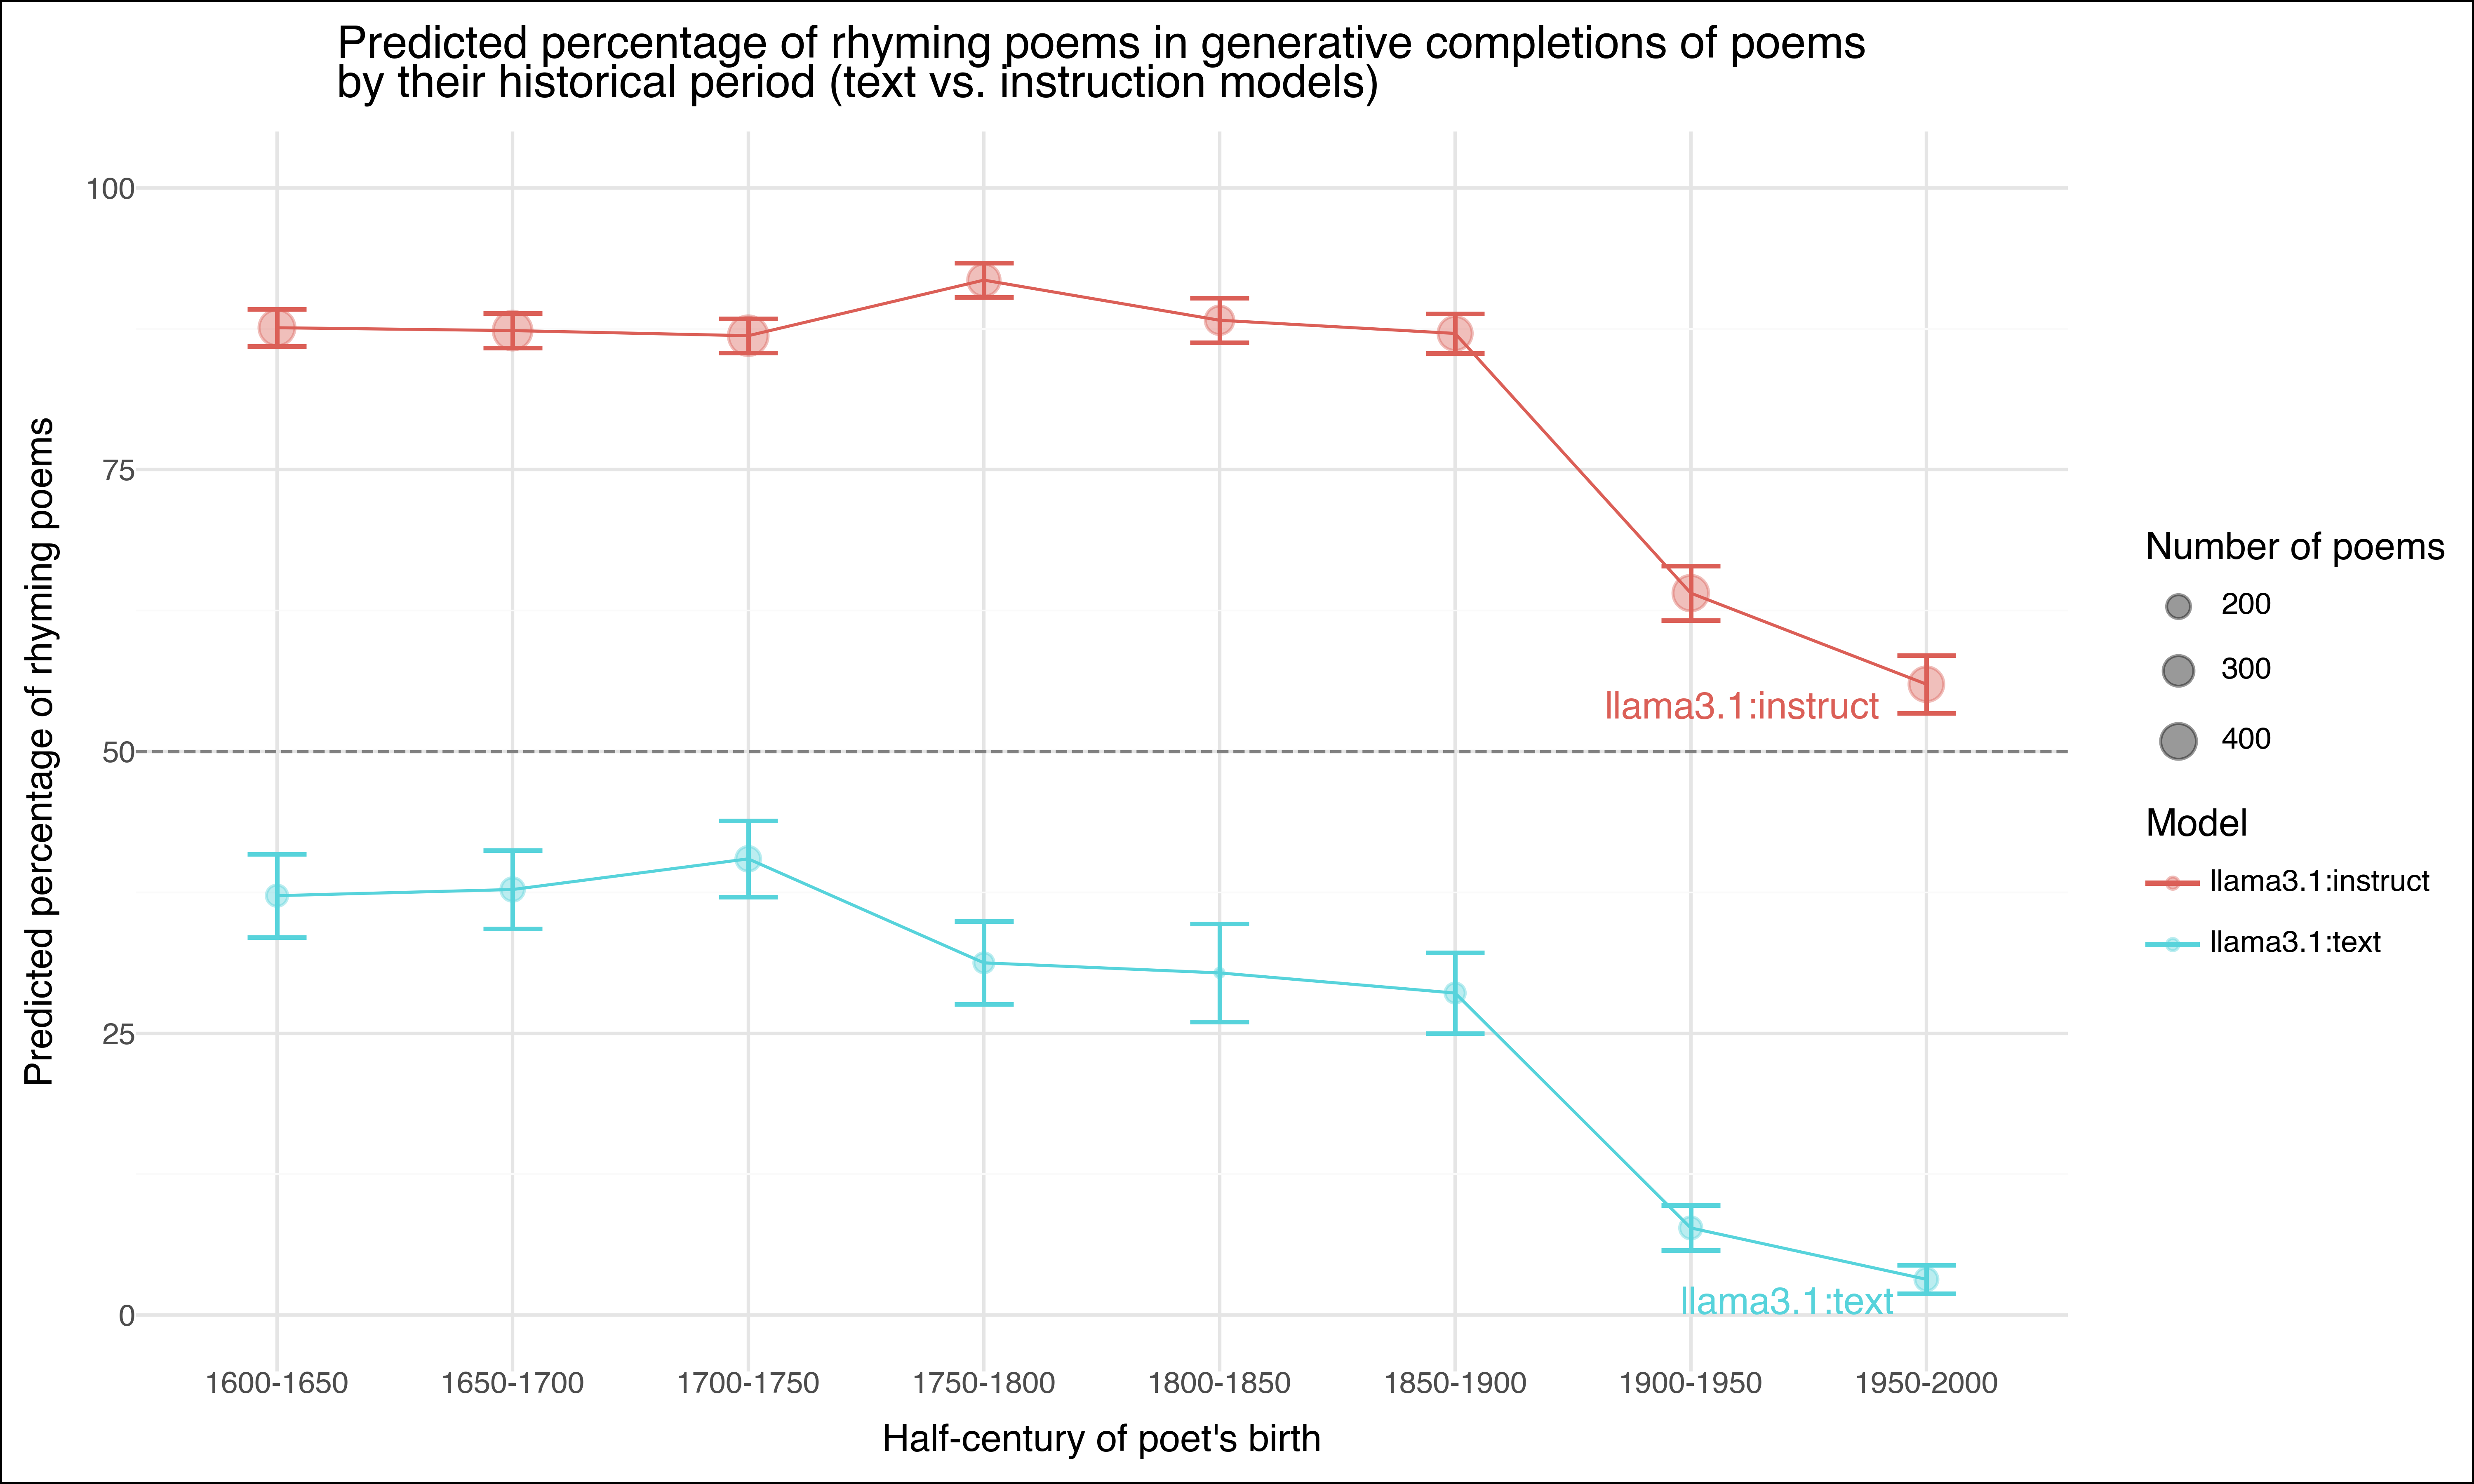

In [25]:
p9.options.figure_size = (10, 6)
models = [x for x in sorted(figdf_avg.model.unique()) if x!=HIST]
figdf_avg['model'] = pd.Categorical(figdf_avg.model, categories=models)

fig = p9.ggplot(figdf_avg, p9.aes(x='period', y='mean', color='model', group='model'))
fig += p9.geom_point(p9.aes(size='count'), shape='o', alpha=.4)
fig += p9.geom_line()
fig += p9.geom_errorbar(
    p9.aes(ymin='mean - stderr', ymax='mean + stderr'),
    width=0.25,
    size=.75,
    # alpha=0.6
)
fig += p9.theme_minimal()

fig += p9.geom_text(
    p9.aes(label='model'),
    data=figdf_avg[figdf_avg.period=='1950-2000'],
    adjust_text={'x':0.05, 'y':0.05, 'arrowprops': dict(arrowstyle='-', alpha=0)},
    
    show_legend=False,
)

fig += p9.theme(panel_background=p9.element_rect(fill='white'), plot_background=p9.element_rect(fill='white'))
fig += p9.geom_hline(yintercept=50, color='gray', linetype='dashed')
fig += p9.scale_y_continuous(limits=(0,100))
fig += p9.labs(
    x='Half-century of poet\'s birth',
    y='Predicted percentage of rhyming poems',
    color='Model',
    size='Number of poems',
    title='Predicted percentage of rhyming poems in generative completions of poems\nby their historical period (text vs. instruction models)',

)
fig.save('../figures/rhyme_by_text_vs_instruction.png')
fig

In [29]:
df_stat_signif = compute_all_stat_signif(df).sort_index()
df_stat_signif

,,p_value,effect_size,effect_size_str,mean1,mean2,significant
groupby,comparison,,,,,,
1600-1650,llama3.1:instruct vs llama3.1:text,0.0,1.316052,large,87.593052,37.209302,True
1650-1700,llama3.1:text vs llama3.1:instruct,0.0,1.289459,large,37.755102,87.339056,True
1700-1750,llama3.1:instruct vs llama3.1:text,0.0,1.188068,large,86.885246,40.476190,True
1750-1800,llama3.1:instruct vs llama3.1:text,0.0,1.739477,large,91.818182,31.250000,True
1800-1850,llama3.1:instruct vs llama3.1:text,0.0,1.567361,large,88.257576,30.357143,True
1850-1900,llama3.1:instruct vs llama3.1:text,0.0,1.557883,large,87.087912,28.571429,True
1900-1950,llama3.1:instruct vs llama3.1:text,0.0,1.323864,large,64.050633,7.734807,True
1950-2000,llama3.1:instruct vs llama3.1:text,0.0,1.261901,large,55.968170,3.174603,True
